In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from pdf2image import convert_from_path
import easyocr
import pandas as pd
from PIL import Image
import os
import shutil
from PIL import Image, ImageDraw, ImageFont


import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'c:\Program Files\Tesseract-OCR\tesseract.exe'

In [26]:
def get_rotation_angle(image):
    # Преобразование в градации серого и применение Canny edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Применение Hough Transform для нахождения линий
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

    # Вычисление углов каждой линии
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi
        angles.append(angle)

    # Вычисление среднего угла наклона
    median_angle = np.median(angles)
    return median_angle

In [27]:
def process_image(file_path):
    # Определение формата файла
    if file_path.lower().endswith('.pdf'):
        # Обработка PDF
        images = convert_from_path(file_path, poppler_path=r"c:\poppler-23.11.0\Library\bin")
        image = cv2.cvtColor(np.array(images[2]), cv2.COLOR_RGB2BGR)  # обработка первой страницы
    else:
        # Обработка изображений в формате JPG
        image = cv2.imread(file_path)
   
   # Получение угла наклона
    angle = get_rotation_angle(image)

    # Поворот изображения
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Вывод или сохранение результатов
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    plt.show()

    return rotated

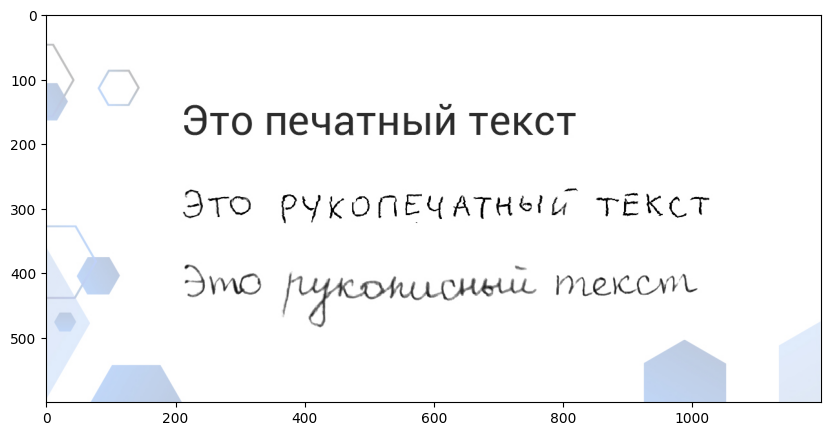

In [28]:
rotated = process_image('data/test_2.jpg')

In [29]:
rotated.shape

(600, 1200, 3)

In [21]:
reader = easyocr.Reader(['ru'])
horizontal_list, _  = reader.detect(rotated)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [30]:
# reader = easyocr.Reader(['ru'])
result  = reader.readtext(rotated)

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

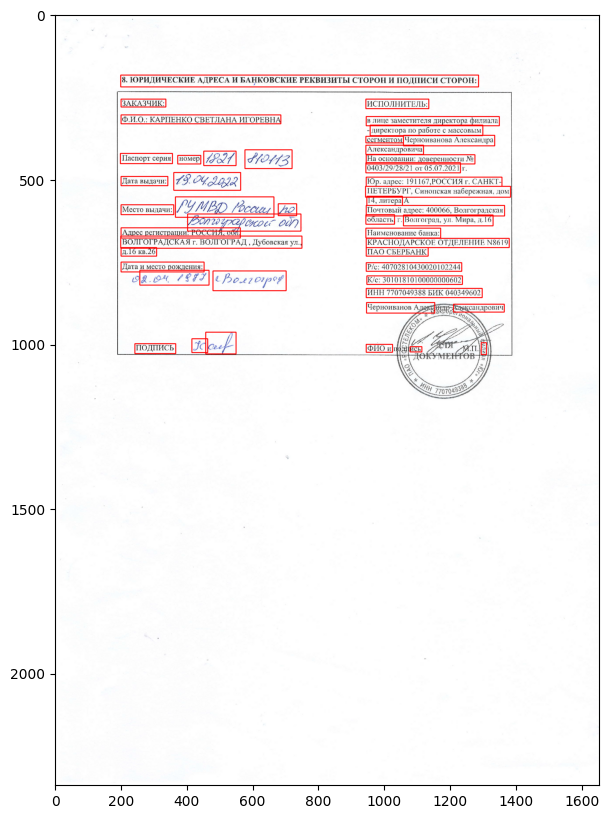

In [8]:
maximum_y = rotated.shape[0]
maximum_x = rotated.shape[1]
rotated_viz = rotated.copy()

for box in horizontal_list[0]:
    x_min = max(0,box[0])
    x_max = min(box[1],maximum_x)
    y_min = max(0,box[2])
    y_max = min(box[3],maximum_y)
    cv2.rectangle(rotated_viz, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# Отображение изображения с нарисованными прямоугольниками
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(rotated_viz, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
data = []

# Извлекаем текст и уровень уверенности для каждого bbox
for bbox in horizontal_list[0]:
    # Вырезаем область изображения по bbox
    x_min, x_max, y_min, y_max = bbox
    crop_img = rotated[y_min:y_max, x_min:x_max]

    # Распознавание текста в этой области
    text = pytesseract.image_to_string(crop_img, lang='rus').strip()  # Используйте 'rus' для русского языка
    
    # Получаем уровень уверенности для распознанного текста
    ocr_data = pytesseract.image_to_data(crop_img, lang='rus', output_type=pytesseract.Output.DICT)
    try:
        # Берем первое значение confidence, которое не равно -1
        confidences = [conf for conf, text in zip(ocr_data['conf'], ocr_data['text']) if conf != -1 and text.strip()]
        confidence = confidences[0] / 100.0 if confidences else -1
    except IndexError:
        confidence = -1

    # Добавляем данные в список
    data.append({'bbox': bbox, 'text': text, 'confidence': confidence})

# Создаем DataFrame из списка
df = pd.DataFrame(data)

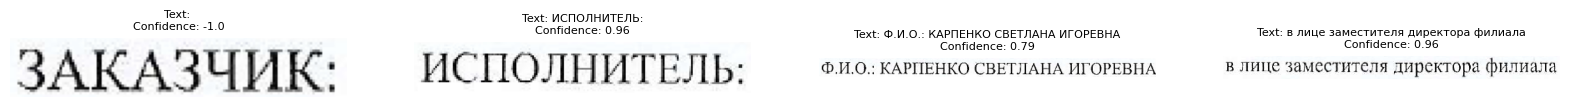

In [10]:
# Загрузите исходное изображение и конвертируйте его в формат PIL
# rotated = cv2.imread('путь_к_вашему_изображению')
pil_image = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))

# Выбор четырех строк DataFrame по индексу
selected_rows = df.iloc[[1,2, 3, 4]]  # Вы можете изменить индексы здесь

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Перебор выбранных строк и отображение изображений с bbox
for ax, (_, row) in zip(axes, selected_rows.iterrows()):
    # Получение координат bbox
    x_min, x_max, y_min, y_max = row['bbox']

    # Обрезка изображения по bbox
    cropped_image = pil_image.crop((x_min, y_min, x_max, y_max))

    # Отображение обрезанного изображения
    ax.imshow(cropped_image)
    ax.axis('off')  # Скрыть оси

    # Установка заголовка с текстом и уровнем уверенности
    ax.set_title(f"Text: {row['text']}\nConfidence: {row['confidence']}", fontsize=8)

# Отображение всех подграфиков
plt.show()

In [11]:
# Загрузите исходное изображение и конвертируйте его в формат PIL
# rotated = cv2.imread('путь_к_вашему_изображению')
pil_image = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))

# Путь к папке 'test'
test_folder_path = 'test'

# Удаление папки 'test', если она существует
if os.path.exists(test_folder_path):
    shutil.rmtree(test_folder_path)

# Создание папки 'test'
os.makedirs(test_folder_path)

# Перебор всех строк DataFrame
for index, row in df.iterrows():
    # Проверка уровня уверенности
    if row['confidence'] < 0.5:
        # Получение координат bbox
        x_min, x_max, y_min, y_max = row['bbox']

        # Корректировка координат bbox, если это необходимо
        x_min, x_max = min(x_min, x_max), max(x_min, x_max)
        y_min, y_max = min(y_min, y_max), max(y_min, y_max)

        # Обрезка изображения по bbox
        cropped_image = pil_image.crop((x_min, y_min, x_max, y_max))

        # Сохранение изображения в папку 'test'
        file_path = os.path.join('test', f'image_{index}.png')
        cropped_image.save(file_path)

In [12]:
!python ocr_transformer/predict.py

transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.0
19,838,174 trainable parameters
loading weights from c:\Users\Vadim\projects\rostelekom_ocr\ocr_transformer_4h2l_simple_conv_64x256.pt
predictions are saved in c:\Users\Vadim\projects\rostelekom_ocrpredictions.tsv


c:\ProgramData\anaconda3\envs\easyenv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
# Чтение файла TSV
predictions_df = pd.read_csv('predictions.tsv', sep='\t')

# Преобразование имени файла в индекс
predictions_df['index'] = predictions_df['filename'].str.extract(r'image_(\d+).png').astype(int)

# Инициализация нового столбца для предсказаний второй модели как столбца строк
df['second_model_prediction'] = None  # или использовать '' для пустой строки

# Обновление значений в df на основе предсказаний второй модели
for idx, row in predictions_df.iterrows():
    df_index = row['index']
    df.at[df_index, 'second_model_prediction'] = row['prediction']

In [14]:
# Создание нового DataFrame с измененными значениями в столбце text
new_df = df.copy()

# Функция для замены текста
def replace_text(row):
    if row['confidence'] < 0.5:
        return row['second_model_prediction']
    else:
        return row['text']

# Применение функции к каждой строке
new_df['text'] = new_df.apply(replace_text, axis=1)
new_df = new_df.drop('second_model_prediction', axis=1)

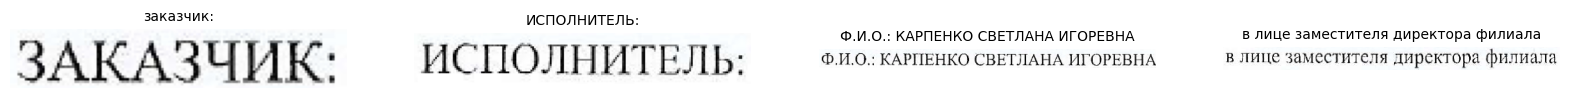

In [15]:
# Загрузите исходное изображение и конвертируйте его в формат PIL
# rotated = cv2.imread('путь_к_вашему_изображению')
pil_image = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))

# Выбор четырех строк DataFrame по индексу
selected_rows = new_df.iloc[[1, 2, 3 , 4]]  # Вы можете изменить индексы здесь

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Перебор выбранных строк и отображение изображений с bbox
for ax, (_, row) in zip(axes, selected_rows.iterrows()):
    # Получение координат bbox
    x_min, x_max, y_min, y_max = row['bbox']

    # Обрезка изображения по bbox
    cropped_image = pil_image.crop((x_min, y_min, x_max, y_max))

    # Отображение обрезанного изображения
    ax.imshow(cropped_image)
    ax.axis('off')  # Скрыть оси

    # Установка заголовка с текстом и уровнем уверенности
    title_text = f"{row['text']}"
    ax.set_title(title_text, fontsize=10)

# Отображение всех подграфиков
plt.show()

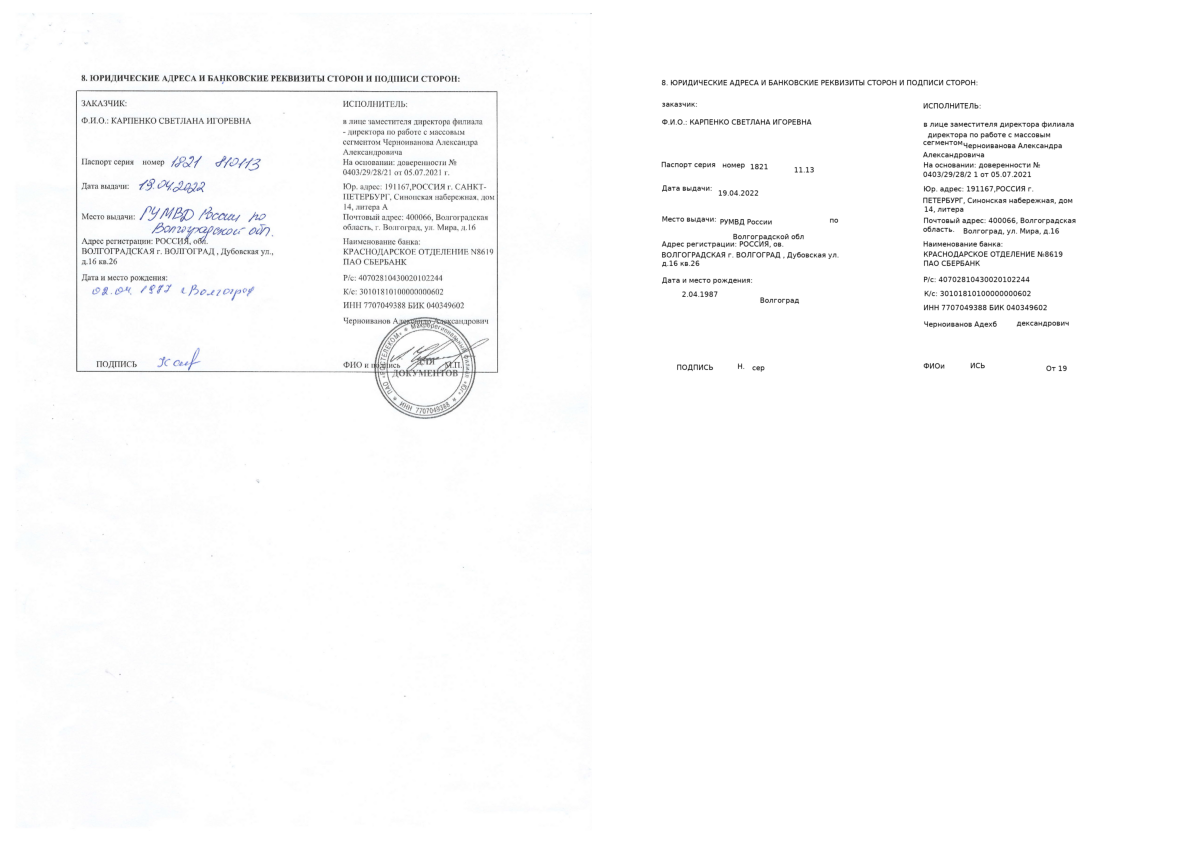

In [16]:
# Загрузка исходного изображения
# rotated = cv2.imread('путь_к_вашему_изображению')
pil_original_image = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))

# Получение размеров исходного изображения
height, width, _ = rotated.shape

# Создание белого изображения тех же размеров для текста
blank_image = Image.new('RGB', (width, height), (255, 255, 255))
draw = ImageDraw.Draw(blank_image)

# Настройки шрифта для текста
font_path = 'DejaVuSans.ttf'  # Укажите путь к файлу шрифта
font_size = 20
font = ImageFont.truetype(font_path, font_size)

# Рисование текста на белом изображении в соответствии с bbox
for _, row in new_df.iterrows():
    x_min, x_max, y_min, y_max = row['bbox']
    text = row['text']
    
    # Расчет позиции для текста
    text_position = (x_min, y_max - font_size)

    # Рисование текста
    draw.text(text_position, text, fill=(0, 0, 0), font=font)

# Создание нового изображения, которое будет включать оба изображения (исходное и с текстом)
total_width = width * 2
combined_image = Image.new('RGB', (total_width, height))

# Размещение исходного и текстового изображений на общей канве
combined_image.paste(pil_original_image, (0, 0))
combined_image.paste(blank_image, (width, 0))

# Отображение результата
plt.figure(figsize=(15, 15))
plt.imshow(combined_image)
plt.axis('off')
plt.show()
